# 7:3 Train/Test Ratio

In [1]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
import numpy

In [2]:
# Read data file
data = pd.read_csv('BIDV.csv')
df = data.reset_index()['Price']

In [3]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# Split train/test to train model
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

27/27 [==============================] - 5s 68ms/step - loss: 0.0193 - val_loss: 0.0037
Epoch 2/100
27/27 [==============================] - 1s 25ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 3/100
27/27 [==============================] - 1s 26ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 4/100
27/27 [==============================] - 1s 27ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 5/100
27/27 [==============================] - 1s 28ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 6/100
27/27 [==============================] - 1s 27ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 7/100
27/27 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 0.0112
Epoch 8/100
27/27 [==============================] - 1s 27ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 9/100
27/27 [==============================] - 1s 26ms/step - loss: 9.9657e-04 - val_loss: 0.0084
Epoch 10/100
27/27 [==============================] - 1s 29ms/step - loss: 9.2252e-04 - val_los

In [10]:
# Forecast test data
y_pred_lstm = model.predict(X_test)

y_pred_new_lstm = scaler.inverse_transform(y_pred_lstm.reshape(1, -1))
y_test_new_lstm = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

23/23 [==============================] - 1s 6ms/step


In [11]:
# Chuẩn hóa dữ liệu y_pred_lstm
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

In [12]:
# Calculate RMSE,MAPE,MSLE 
test_score_rmse_lstm = np.sqrt(mean_squared_error(y_test_new_lstm, y_pred_new_lstm))
test_score_mape_lstm = mean_absolute_percentage_error(y_test_new_lstm, y_pred_new_lstm) * 100
test_score_msle_lstm = mean_squared_log_error(y_test_new_lstm, y_pred_new_lstm)

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 1039.548
MAPE trên tập test là: 2.0669808611273766
MSLE trên tập test là: 0.00071383925


In [13]:
# 13. Forecast next 30 day
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8161379]
683
1 day input [0.68242257 0.6679775  0.65834826 0.66701628 0.64583049 0.6525712
 0.63427395 0.61405182 0.63331273 0.63716491 0.59479335 0.61405182
 0.58516411 0.58227559 0.58708899 0.59479335 0.60057041 0.61212695
 0.59960918 0.58805264 0.60249771 0.61597913 0.62657202 0.62560837
 0.62079253 0.61019964 0.59286848 0.59286848 0.6111633  0.66701628
 0.69109058 0.704572   0.70360835 0.67953404 0.71323758 0.74308895
 0.72960753 0.71805342 0.74501626 0.748866   0.70649688 0.6679775
 0.68049769 0.65064633 0.67568186 0.6699048  0.6699048  0.67760917
 0.68916328 0.69397911 0.67182968 0.67182968 0.67953404 0.67568186
 0.68242257 0.70842175 0.70842175 0.71516246 0.71612611 0.71131271
 0.70360835 0.6525712  0.68145891 0.6872384  0.6699048  0.61405182
 0.62175619 0.62560837 0.62753324 0.62368349 0.56879417 0.59479335
 0.58901629 0.59479335 0.57938706 0.57553488 0.57938706 0.58516411
 0.59479335 0.59671822 0.62464471 0.64005344 0.63331273 0.63234908
 0.63138542 0.63620126 0.63908979 0.

3 day output [[0.7695465]]
4 day input [0.66701628 0.64583049 0.6525712  0.63427395 0.61405182 0.63331273
 0.63716491 0.59479335 0.61405182 0.58516411 0.58227559 0.58708899
 0.59479335 0.60057041 0.61212695 0.59960918 0.58805264 0.60249771
 0.61597913 0.62657202 0.62560837 0.62079253 0.61019964 0.59286848
 0.59286848 0.6111633  0.66701628 0.69109058 0.704572   0.70360835
 0.67953404 0.71323758 0.74308895 0.72960753 0.71805342 0.74501626
 0.748866   0.70649688 0.6679775  0.68049769 0.65064633 0.67568186
 0.6699048  0.6699048  0.67760917 0.68916328 0.69397911 0.67182968
 0.67182968 0.67953404 0.67568186 0.68242257 0.70842175 0.70842175
 0.71516246 0.71612611 0.71131271 0.70360835 0.6525712  0.68145891
 0.6872384  0.6699048  0.61405182 0.62175619 0.62560837 0.62753324
 0.62368349 0.56879417 0.59479335 0.58901629 0.59479335 0.57938706
 0.57553488 0.57938706 0.58516411 0.59479335 0.59671822 0.62464471
 0.64005344 0.63331273 0.63234908 0.63138542 0.63620126 0.63908979
 0.6352376  0.62946055 

6 day output [[0.72798574]]
7 day input [0.63427395 0.61405182 0.63331273 0.63716491 0.59479335 0.61405182
 0.58516411 0.58227559 0.58708899 0.59479335 0.60057041 0.61212695
 0.59960918 0.58805264 0.60249771 0.61597913 0.62657202 0.62560837
 0.62079253 0.61019964 0.59286848 0.59286848 0.6111633  0.66701628
 0.69109058 0.704572   0.70360835 0.67953404 0.71323758 0.74308895
 0.72960753 0.71805342 0.74501626 0.748866   0.70649688 0.6679775
 0.68049769 0.65064633 0.67568186 0.6699048  0.6699048  0.67760917
 0.68916328 0.69397911 0.67182968 0.67182968 0.67953404 0.67568186
 0.68242257 0.70842175 0.70842175 0.71516246 0.71612611 0.71131271
 0.70360835 0.6525712  0.68145891 0.6872384  0.6699048  0.61405182
 0.62175619 0.62560837 0.62753324 0.62368349 0.56879417 0.59479335
 0.58901629 0.59479335 0.57938706 0.57553488 0.57938706 0.58516411
 0.59479335 0.59671822 0.62464471 0.64005344 0.63331273 0.63234908
 0.63138542 0.63620126 0.63908979 0.6352376  0.62946055 0.62464471
 0.63908979 0.63234908 

9 day output [[0.68684113]]
10 day input [0.63716491 0.59479335 0.61405182 0.58516411 0.58227559 0.58708899
 0.59479335 0.60057041 0.61212695 0.59960918 0.58805264 0.60249771
 0.61597913 0.62657202 0.62560837 0.62079253 0.61019964 0.59286848
 0.59286848 0.6111633  0.66701628 0.69109058 0.704572   0.70360835
 0.67953404 0.71323758 0.74308895 0.72960753 0.71805342 0.74501626
 0.748866   0.70649688 0.6679775  0.68049769 0.65064633 0.67568186
 0.6699048  0.6699048  0.67760917 0.68916328 0.69397911 0.67182968
 0.67182968 0.67953404 0.67568186 0.68242257 0.70842175 0.70842175
 0.71516246 0.71612611 0.71131271 0.70360835 0.6525712  0.68145891
 0.6872384  0.6699048  0.61405182 0.62175619 0.62560837 0.62753324
 0.62368349 0.56879417 0.59479335 0.58901629 0.59479335 0.57938706
 0.57553488 0.57938706 0.58516411 0.59479335 0.59671822 0.62464471
 0.64005344 0.63331273 0.63234908 0.63138542 0.63620126 0.63908979
 0.6352376  0.62946055 0.62464471 0.63908979 0.63234908 0.62657202
 0.62368349 0.5851641

12 day output [[0.6406478]]
13 day input [0.58516411 0.58227559 0.58708899 0.59479335 0.60057041 0.61212695
 0.59960918 0.58805264 0.60249771 0.61597913 0.62657202 0.62560837
 0.62079253 0.61019964 0.59286848 0.59286848 0.6111633  0.66701628
 0.69109058 0.704572   0.70360835 0.67953404 0.71323758 0.74308895
 0.72960753 0.71805342 0.74501626 0.748866   0.70649688 0.6679775
 0.68049769 0.65064633 0.67568186 0.6699048  0.6699048  0.67760917
 0.68916328 0.69397911 0.67182968 0.67182968 0.67953404 0.67568186
 0.68242257 0.70842175 0.70842175 0.71516246 0.71612611 0.71131271
 0.70360835 0.6525712  0.68145891 0.6872384  0.6699048  0.61405182
 0.62175619 0.62560837 0.62753324 0.62368349 0.56879417 0.59479335
 0.58901629 0.59479335 0.57938706 0.57553488 0.57938706 0.58516411
 0.59479335 0.59671822 0.62464471 0.64005344 0.63331273 0.63234908
 0.63138542 0.63620126 0.63908979 0.6352376  0.62946055 0.62464471
 0.63908979 0.63234908 0.62657202 0.62368349 0.58516411 0.56205346
 0.56397833 0.56494199

15 day output [[0.5930785]]
16 day input [0.59479335 0.60057041 0.61212695 0.59960918 0.58805264 0.60249771
 0.61597913 0.62657202 0.62560837 0.62079253 0.61019964 0.59286848
 0.59286848 0.6111633  0.66701628 0.69109058 0.704572   0.70360835
 0.67953404 0.71323758 0.74308895 0.72960753 0.71805342 0.74501626
 0.748866   0.70649688 0.6679775  0.68049769 0.65064633 0.67568186
 0.6699048  0.6699048  0.67760917 0.68916328 0.69397911 0.67182968
 0.67182968 0.67953404 0.67568186 0.68242257 0.70842175 0.70842175
 0.71516246 0.71612611 0.71131271 0.70360835 0.6525712  0.68145891
 0.6872384  0.6699048  0.61405182 0.62175619 0.62560837 0.62753324
 0.62368349 0.56879417 0.59479335 0.58901629 0.59479335 0.57938706
 0.57553488 0.57938706 0.58516411 0.59479335 0.59671822 0.62464471
 0.64005344 0.63331273 0.63234908 0.63138542 0.63620126 0.63908979
 0.6352376  0.62946055 0.62464471 0.63908979 0.63234908 0.62657202
 0.62368349 0.58516411 0.56205346 0.56397833 0.56494199 0.54857204
 0.55049691 0.5649419

18 day output [[0.54853386]]
19 day input [0.59960918 0.58805264 0.60249771 0.61597913 0.62657202 0.62560837
 0.62079253 0.61019964 0.59286848 0.59286848 0.6111633  0.66701628
 0.69109058 0.704572   0.70360835 0.67953404 0.71323758 0.74308895
 0.72960753 0.71805342 0.74501626 0.748866   0.70649688 0.6679775
 0.68049769 0.65064633 0.67568186 0.6699048  0.6699048  0.67760917
 0.68916328 0.69397911 0.67182968 0.67182968 0.67953404 0.67568186
 0.68242257 0.70842175 0.70842175 0.71516246 0.71612611 0.71131271
 0.70360835 0.6525712  0.68145891 0.6872384  0.6699048  0.61405182
 0.62175619 0.62560837 0.62753324 0.62368349 0.56879417 0.59479335
 0.58901629 0.59479335 0.57938706 0.57553488 0.57938706 0.58516411
 0.59479335 0.59671822 0.62464471 0.64005344 0.63331273 0.63234908
 0.63138542 0.63620126 0.63908979 0.6352376  0.62946055 0.62464471
 0.63908979 0.63234908 0.62657202 0.62368349 0.58516411 0.56205346
 0.56397833 0.56494199 0.54857204 0.55049691 0.56494199 0.55531275
 0.55627397 0.5582012

21 day output [[0.5092467]]
22 day input [0.61597913 0.62657202 0.62560837 0.62079253 0.61019964 0.59286848
 0.59286848 0.6111633  0.66701628 0.69109058 0.704572   0.70360835
 0.67953404 0.71323758 0.74308895 0.72960753 0.71805342 0.74501626
 0.748866   0.70649688 0.6679775  0.68049769 0.65064633 0.67568186
 0.6699048  0.6699048  0.67760917 0.68916328 0.69397911 0.67182968
 0.67182968 0.67953404 0.67568186 0.68242257 0.70842175 0.70842175
 0.71516246 0.71612611 0.71131271 0.70360835 0.6525712  0.68145891
 0.6872384  0.6699048  0.61405182 0.62175619 0.62560837 0.62753324
 0.62368349 0.56879417 0.59479335 0.58901629 0.59479335 0.57938706
 0.57553488 0.57938706 0.58516411 0.59479335 0.59671822 0.62464471
 0.64005344 0.63331273 0.63234908 0.63138542 0.63620126 0.63908979
 0.6352376  0.62946055 0.62464471 0.63908979 0.63234908 0.62657202
 0.62368349 0.58516411 0.56205346 0.56397833 0.56494199 0.54857204
 0.55049691 0.56494199 0.55531275 0.55627397 0.55820128 0.56975539
 0.56783051 0.5716827

24 day output [[0.47628108]]
25 day input [0.62079253 0.61019964 0.59286848 0.59286848 0.6111633  0.66701628
 0.69109058 0.704572   0.70360835 0.67953404 0.71323758 0.74308895
 0.72960753 0.71805342 0.74501626 0.748866   0.70649688 0.6679775
 0.68049769 0.65064633 0.67568186 0.6699048  0.6699048  0.67760917
 0.68916328 0.69397911 0.67182968 0.67182968 0.67953404 0.67568186
 0.68242257 0.70842175 0.70842175 0.71516246 0.71612611 0.71131271
 0.70360835 0.6525712  0.68145891 0.6872384  0.6699048  0.61405182
 0.62175619 0.62560837 0.62753324 0.62368349 0.56879417 0.59479335
 0.58901629 0.59479335 0.57938706 0.57553488 0.57938706 0.58516411
 0.59479335 0.59671822 0.62464471 0.64005344 0.63331273 0.63234908
 0.63138542 0.63620126 0.63908979 0.6352376  0.62946055 0.62464471
 0.63908979 0.63234908 0.62657202 0.62368349 0.58516411 0.56205346
 0.56397833 0.56494199 0.54857204 0.55049691 0.56494199 0.55531275
 0.55627397 0.55820128 0.56975539 0.56783051 0.5716827  0.56879417
 0.55916493 0.5504969

27 day output [[0.44999257]]
28 day input [0.59286848 0.6111633  0.66701628 0.69109058 0.704572   0.70360835
 0.67953404 0.71323758 0.74308895 0.72960753 0.71805342 0.74501626
 0.748866   0.70649688 0.6679775  0.68049769 0.65064633 0.67568186
 0.6699048  0.6699048  0.67760917 0.68916328 0.69397911 0.67182968
 0.67182968 0.67953404 0.67568186 0.68242257 0.70842175 0.70842175
 0.71516246 0.71612611 0.71131271 0.70360835 0.6525712  0.68145891
 0.6872384  0.6699048  0.61405182 0.62175619 0.62560837 0.62753324
 0.62368349 0.56879417 0.59479335 0.58901629 0.59479335 0.57938706
 0.57553488 0.57938706 0.58516411 0.59479335 0.59671822 0.62464471
 0.64005344 0.63331273 0.63234908 0.63138542 0.63620126 0.63908979
 0.6352376  0.62946055 0.62464471 0.63908979 0.63234908 0.62657202
 0.62368349 0.58516411 0.56205346 0.56397833 0.56494199 0.54857204
 0.55049691 0.56494199 0.55531275 0.55627397 0.55820128 0.56975539
 0.56783051 0.5716827  0.56879417 0.55916493 0.55049691 0.55242422
 0.56397833 0.575534

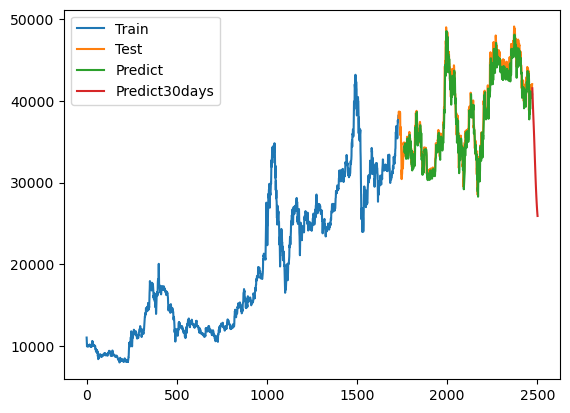

In [14]:
# Plot 
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_lstm)

predict_data_index = pd.RangeIndex(start=len(df), stop=len(df)+30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

# 8:2 Train/Test Ratio

In [15]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
import numpy

In [16]:
# Read data file
data = pd.read_csv('BIDV.csv')
df = data.reset_index()['Price']
df

0       11054.8
1       10574.2
2        9973.4
3       10213.7
4       10153.6
         ...   
2467    41000.0
2468    41200.0
2469    41300.0
2470    41800.0
2471    42050.0
Name: Price, Length: 2472, dtype: float64

In [17]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [18]:
# Split train/test to train model
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [19]:
# Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [21]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
# 9. Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
31/31 [==============================] - 6s 60ms/step - loss: 0.0245 - val_loss: 0.0078
Epoch 2/100
31/31 [==============================] - 1s 36ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 3/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 4/100
31/31 [==============================] - 1s 32ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 5/100
31/31 [==============================] - 1s 32ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 7/100
31/31 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 8/100
31/31 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 9/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 10/100
31/31 [==============================] - 1s 35ms/step - loss: 9.6803e-04 - val_loss: 0.

31/31 [==============================] - 1s 24ms/step - loss: 2.1538e-04 - val_loss: 8.6038e-04
Epoch 79/100
31/31 [==============================] - 1s 23ms/step - loss: 2.2013e-04 - val_loss: 4.8889e-04
Epoch 80/100
31/31 [==============================] - 1s 22ms/step - loss: 2.2367e-04 - val_loss: 0.0015
Epoch 81/100
31/31 [==============================] - 1s 23ms/step - loss: 2.5897e-04 - val_loss: 8.8642e-04
Epoch 82/100
31/31 [==============================] - 1s 25ms/step - loss: 2.3425e-04 - val_loss: 7.5809e-04
Epoch 83/100
31/31 [==============================] - 1s 23ms/step - loss: 2.8128e-04 - val_loss: 7.5827e-04
Epoch 84/100
31/31 [==============================] - 1s 22ms/step - loss: 2.4668e-04 - val_loss: 5.3674e-04
Epoch 85/100
31/31 [==============================] - 1s 22ms/step - loss: 2.3705e-04 - val_loss: 6.0546e-04
Epoch 86/100
31/31 [==============================] - 1s 22ms/step - loss: 2.3295e-04 - val_loss: 0.0010
Epoch 87/100
31/31 [====================

In [24]:
# Forecast test data
y_pred_lstm = model.predict(X_test)

y_pred_new_lstm = scaler.inverse_transform(y_pred_lstm.reshape(1, -1))
y_test_new_lstm = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

15/15 [==============================] - 1s 6ms/step


In [25]:
# Chuẩn hóa dữ liệu y_pred_lstm
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

In [26]:
# Calculate RMSE,MAPE,MSLE 
test_score_rmse_lstm = np.sqrt(mean_squared_error(y_test_new_lstm, y_pred_new_lstm))
test_score_mape_lstm = mean_absolute_percentage_error(y_test_new_lstm, y_pred_new_lstm) * 100
test_score_msle_lstm = mean_squared_log_error(y_test_new_lstm, y_pred_new_lstm)

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 927.69543
MAPE trên tập test là: 1.7464729025959969
MSLE trên tập test là: 0.0005704458


In [27]:
# 13. Forecast next 30 day
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.82585794]
436
1 day input [0.88197676 0.8588588  0.86372574 0.85277513 0.82479023 0.78950494
 0.80045555 0.79072167 0.76152004 0.72866821 0.72866821 0.72866821
 0.74205229 0.74205229 0.67756536 0.70311679 0.71041719 0.69824985
 0.71163393 0.71163393 0.73475188 0.70555026 0.6434968  0.67634863
 0.68364904 0.62281231 0.57900987 0.58874375 0.6434968  0.65444741
 0.64836374 0.64471353 0.61672864 0.62646251 0.65444741 0.65931435
 0.66418128 0.67513189 0.66418128 0.66053108 0.64958047 0.64106333
 0.63741313 0.62281231 0.63984659 0.64471353 0.62767925 0.58266007
 0.59117721 0.58387681 0.59117721 0.57414293 0.52304008 0.54250784
 0.54737477 0.55954212 0.56440906 0.57779314 0.62402905 0.65444741
 0.62037884 0.65809761 0.65809761 0.68851597 0.67148169 0.68851597
 0.65688088 0.64471353 0.69094944 0.6824323  0.68486577 0.67634863
 0.66904822 0.67269843 0.69094944 0.69338291 0.66904822 0.66661475
 0.67026496 0.67026496 0.69338291 0.71285066 0.75421964 0.74205229
 0.76152004 0.76152004 0.75421964

4 day output [[0.81360525]]
5 day input [0.82479023 0.78950494 0.80045555 0.79072167 0.76152004 0.72866821
 0.72866821 0.72866821 0.74205229 0.74205229 0.67756536 0.70311679
 0.71041719 0.69824985 0.71163393 0.71163393 0.73475188 0.70555026
 0.6434968  0.67634863 0.68364904 0.62281231 0.57900987 0.58874375
 0.6434968  0.65444741 0.64836374 0.64471353 0.61672864 0.62646251
 0.65444741 0.65931435 0.66418128 0.67513189 0.66418128 0.66053108
 0.64958047 0.64106333 0.63741313 0.62281231 0.63984659 0.64471353
 0.62767925 0.58266007 0.59117721 0.58387681 0.59117721 0.57414293
 0.52304008 0.54250784 0.54737477 0.55954212 0.56440906 0.57779314
 0.62402905 0.65444741 0.62037884 0.65809761 0.65809761 0.68851597
 0.67148169 0.68851597 0.65688088 0.64471353 0.69094944 0.6824323
 0.68486577 0.67634863 0.66904822 0.67269843 0.69094944 0.69338291
 0.66904822 0.66661475 0.67026496 0.67026496 0.69338291 0.71285066
 0.75421964 0.74205229 0.76152004 0.76152004 0.75421964 0.7493527
 0.74570249 0.73961882 0

8 day output [[0.8023119]]
9 day input [0.76152004 0.72866821 0.72866821 0.72866821 0.74205229 0.74205229
 0.67756536 0.70311679 0.71041719 0.69824985 0.71163393 0.71163393
 0.73475188 0.70555026 0.6434968  0.67634863 0.68364904 0.62281231
 0.57900987 0.58874375 0.6434968  0.65444741 0.64836374 0.64471353
 0.61672864 0.62646251 0.65444741 0.65931435 0.66418128 0.67513189
 0.66418128 0.66053108 0.64958047 0.64106333 0.63741313 0.62281231
 0.63984659 0.64471353 0.62767925 0.58266007 0.59117721 0.58387681
 0.59117721 0.57414293 0.52304008 0.54250784 0.54737477 0.55954212
 0.56440906 0.57779314 0.62402905 0.65444741 0.62037884 0.65809761
 0.65809761 0.68851597 0.67148169 0.68851597 0.65688088 0.64471353
 0.69094944 0.6824323  0.68486577 0.67634863 0.66904822 0.67269843
 0.69094944 0.69338291 0.66904822 0.66661475 0.67026496 0.67026496
 0.69338291 0.71285066 0.75421964 0.74205229 0.76152004 0.76152004
 0.75421964 0.7493527  0.74570249 0.73961882 0.73718535 0.75908657
 0.80288901 0.79072167 

12 day output [[0.7887233]]
13 day input [0.74205229 0.74205229 0.67756536 0.70311679 0.71041719 0.69824985
 0.71163393 0.71163393 0.73475188 0.70555026 0.6434968  0.67634863
 0.68364904 0.62281231 0.57900987 0.58874375 0.6434968  0.65444741
 0.64836374 0.64471353 0.61672864 0.62646251 0.65444741 0.65931435
 0.66418128 0.67513189 0.66418128 0.66053108 0.64958047 0.64106333
 0.63741313 0.62281231 0.63984659 0.64471353 0.62767925 0.58266007
 0.59117721 0.58387681 0.59117721 0.57414293 0.52304008 0.54250784
 0.54737477 0.55954212 0.56440906 0.57779314 0.62402905 0.65444741
 0.62037884 0.65809761 0.65809761 0.68851597 0.67148169 0.68851597
 0.65688088 0.64471353 0.69094944 0.6824323  0.68486577 0.67634863
 0.66904822 0.67269843 0.69094944 0.69338291 0.66904822 0.66661475
 0.67026496 0.67026496 0.69338291 0.71285066 0.75421964 0.74205229
 0.76152004 0.76152004 0.75421964 0.7493527  0.74570249 0.73961882
 0.73718535 0.75908657 0.80288901 0.79072167 0.77855432 0.76882045
 0.76273678 0.7408355

16 day input [0.70311679 0.71041719 0.69824985 0.71163393 0.71163393 0.73475188
 0.70555026 0.6434968  0.67634863 0.68364904 0.62281231 0.57900987
 0.58874375 0.6434968  0.65444741 0.64836374 0.64471353 0.61672864
 0.62646251 0.65444741 0.65931435 0.66418128 0.67513189 0.66418128
 0.66053108 0.64958047 0.64106333 0.63741313 0.62281231 0.63984659
 0.64471353 0.62767925 0.58266007 0.59117721 0.58387681 0.59117721
 0.57414293 0.52304008 0.54250784 0.54737477 0.55954212 0.56440906
 0.57779314 0.62402905 0.65444741 0.62037884 0.65809761 0.65809761
 0.68851597 0.67148169 0.68851597 0.65688088 0.64471353 0.69094944
 0.6824323  0.68486577 0.67634863 0.66904822 0.67269843 0.69094944
 0.69338291 0.66904822 0.66661475 0.67026496 0.67026496 0.69338291
 0.71285066 0.75421964 0.74205229 0.76152004 0.76152004 0.75421964
 0.7493527  0.74570249 0.73961882 0.73718535 0.75908657 0.80288901
 0.79072167 0.77855432 0.76882045 0.76273678 0.74083556 0.76638698
 0.76152004 0.76152004 0.76395351 0.75421964 0.77

19 day output [[0.76330084]]
20 day input [0.71163393 0.73475188 0.70555026 0.6434968  0.67634863 0.68364904
 0.62281231 0.57900987 0.58874375 0.6434968  0.65444741 0.64836374
 0.64471353 0.61672864 0.62646251 0.65444741 0.65931435 0.66418128
 0.67513189 0.66418128 0.66053108 0.64958047 0.64106333 0.63741313
 0.62281231 0.63984659 0.64471353 0.62767925 0.58266007 0.59117721
 0.58387681 0.59117721 0.57414293 0.52304008 0.54250784 0.54737477
 0.55954212 0.56440906 0.57779314 0.62402905 0.65444741 0.62037884
 0.65809761 0.65809761 0.68851597 0.67148169 0.68851597 0.65688088
 0.64471353 0.69094944 0.6824323  0.68486577 0.67634863 0.66904822
 0.67269843 0.69094944 0.69338291 0.66904822 0.66661475 0.67026496
 0.67026496 0.69338291 0.71285066 0.75421964 0.74205229 0.76152004
 0.76152004 0.75421964 0.7493527  0.74570249 0.73961882 0.73718535
 0.75908657 0.80288901 0.79072167 0.77855432 0.76882045 0.76273678
 0.74083556 0.76638698 0.76152004 0.76152004 0.76395351 0.75421964
 0.77368739 0.778554

23 day output [[0.7505448]]
24 day input [0.67634863 0.68364904 0.62281231 0.57900987 0.58874375 0.6434968
 0.65444741 0.64836374 0.64471353 0.61672864 0.62646251 0.65444741
 0.65931435 0.66418128 0.67513189 0.66418128 0.66053108 0.64958047
 0.64106333 0.63741313 0.62281231 0.63984659 0.64471353 0.62767925
 0.58266007 0.59117721 0.58387681 0.59117721 0.57414293 0.52304008
 0.54250784 0.54737477 0.55954212 0.56440906 0.57779314 0.62402905
 0.65444741 0.62037884 0.65809761 0.65809761 0.68851597 0.67148169
 0.68851597 0.65688088 0.64471353 0.69094944 0.6824323  0.68486577
 0.67634863 0.66904822 0.67269843 0.69094944 0.69338291 0.66904822
 0.66661475 0.67026496 0.67026496 0.69338291 0.71285066 0.75421964
 0.74205229 0.76152004 0.76152004 0.75421964 0.7493527  0.74570249
 0.73961882 0.73718535 0.75908657 0.80288901 0.79072167 0.77855432
 0.76882045 0.76273678 0.74083556 0.76638698 0.76152004 0.76152004
 0.76395351 0.75421964 0.77368739 0.77855432 0.76638698 0.77977106
 0.72501801 0.69824985

27 day output [[0.7400366]]
28 day input [0.58874375 0.6434968  0.65444741 0.64836374 0.64471353 0.61672864
 0.62646251 0.65444741 0.65931435 0.66418128 0.67513189 0.66418128
 0.66053108 0.64958047 0.64106333 0.63741313 0.62281231 0.63984659
 0.64471353 0.62767925 0.58266007 0.59117721 0.58387681 0.59117721
 0.57414293 0.52304008 0.54250784 0.54737477 0.55954212 0.56440906
 0.57779314 0.62402905 0.65444741 0.62037884 0.65809761 0.65809761
 0.68851597 0.67148169 0.68851597 0.65688088 0.64471353 0.69094944
 0.6824323  0.68486577 0.67634863 0.66904822 0.67269843 0.69094944
 0.69338291 0.66904822 0.66661475 0.67026496 0.67026496 0.69338291
 0.71285066 0.75421964 0.74205229 0.76152004 0.76152004 0.75421964
 0.7493527  0.74570249 0.73961882 0.73718535 0.75908657 0.80288901
 0.79072167 0.77855432 0.76882045 0.76273678 0.74083556 0.76638698
 0.76152004 0.76152004 0.76395351 0.75421964 0.77368739 0.77855432
 0.76638698 0.77977106 0.72501801 0.69824985 0.70555026 0.70311679
 0.70068332 0.6933829

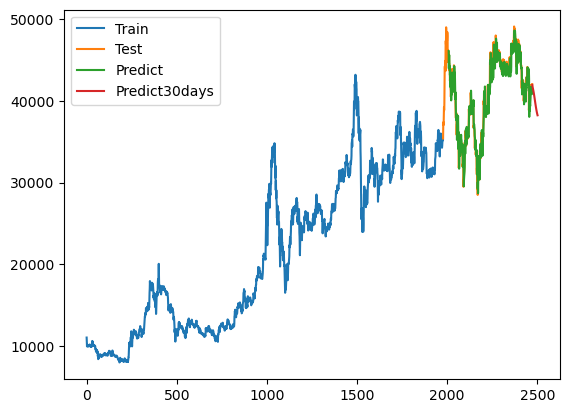

In [28]:
# Plot 
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_lstm)

predict_data_index = pd.RangeIndex(start=len(df), stop=len(df)+30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

# 9:1 Train/Test Ratio

In [29]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
import numpy

In [30]:
# Read data file
data = pd.read_csv('BIDV.csv')
df = data.reset_index()['Price']
df

0       11054.8
1       10574.2
2        9973.4
3       10213.7
4       10153.6
         ...   
2467    41000.0
2468    41200.0
2469    41300.0
2470    41800.0
2471    42050.0
Name: Price, Length: 2472, dtype: float64

In [31]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [32]:
# Split train/test to train model
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [33]:
# Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [35]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [36]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
# 9. Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
35/35 [==============================] - 5s 47ms/step - loss: 0.0206 - val_loss: 0.0023
Epoch 2/100
35/35 [==============================] - 1s 24ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 3/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/100
35/35 [==============================] - 1s 23ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 5/100
35/35 [==============================] - 1s 23ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/100
35/35 [==============================] - 1s 24ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 7/100
35/35 [==============================] - 1s 24ms/step - loss: 0.0015 - val_loss: 0.0062
Epoch 8/100
35/35 [==============================] - 1s 24ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/100
35/35 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0027

Epoch 78/100
35/35 [==============================] - 1s 23ms/step - loss: 2.7288e-04 - val_loss: 3.3779e-04
Epoch 79/100
35/35 [==============================] - 1s 20ms/step - loss: 2.6603e-04 - val_loss: 3.1925e-04
Epoch 80/100
35/35 [==============================] - 1s 21ms/step - loss: 2.8360e-04 - val_loss: 7.0515e-04
Epoch 81/100
35/35 [==============================] - 1s 22ms/step - loss: 2.6232e-04 - val_loss: 3.1740e-04
Epoch 82/100
35/35 [==============================] - 1s 28ms/step - loss: 2.7000e-04 - val_loss: 8.4710e-04
Epoch 83/100
35/35 [==============================] - 1s 24ms/step - loss: 2.9278e-04 - val_loss: 4.8040e-04
Epoch 84/100
35/35 [==============================] - 1s 24ms/step - loss: 2.8509e-04 - val_loss: 3.6735e-04
Epoch 85/100
35/35 [==============================] - 1s 24ms/step - loss: 2.7208e-04 - val_loss: 8.0090e-04
Epoch 86/100
35/35 [==============================] - 1s 24ms/step - loss: 3.0100e-04 - val_loss: 9.8867e-04
Epoch 87/100
35/35 

In [38]:
# Forecast test data
y_pred_lstm = model.predict(X_test)

y_pred_new_lstm = scaler.inverse_transform(y_pred_lstm.reshape(1, -1))
y_test_new_lstm = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

7/7 [==============================] - 1s 6ms/step


In [39]:
# Chuẩn hóa dữ liệu y_pred_lstm
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

In [40]:
# Calculate RMSE,MAPE,MSLE 
test_score_rmse_lstm = np.sqrt(mean_squared_error(y_test_new_lstm, y_pred_new_lstm))
test_score_mape_lstm = mean_absolute_percentage_error(y_test_new_lstm, y_pred_new_lstm) * 100
test_score_msle_lstm = mean_squared_log_error(y_test_new_lstm, y_pred_new_lstm)

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 1429.3533
MAPE trên tập test là: 2.841608040034771
MSLE trên tập test là: 0.0010172005


In [41]:
# 13. Forecast next 30 day
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.85959536]
189
1 day input [0.9294294  0.9294294  0.92212899 0.92456246 0.91239512 0.92456246
 0.91604532 0.89292737 0.88562696 0.88562696 0.89901104 0.88684369
 0.90022777 0.8904939  0.88562696 0.8904939  0.88076002 0.86859268
 0.86494247 0.87832655 0.87345961 0.86372574 0.86980941 0.862509
 0.89292737 0.90266124 0.90022777 0.90022777 0.90022777 0.8977943
 0.90022777 0.89536083 0.89171063 0.88562696 0.88562696 0.87224288
 0.86372574 0.86980941 0.86129227 0.87345961 0.87102615 0.87589308
 0.87345961 0.89292737 0.89292737 0.89536083 0.88441022 0.86859268
 0.862509   0.86737594 0.88441022 0.87589308 0.87224288 0.86859268
 0.8588588  0.86372574 0.86129227 0.87467635 0.88319349 0.88319349
 0.88319349 0.90874491 0.88806043 0.86007553 0.88806043 0.87589308
 0.88441022 0.87467635 0.88319349 0.94768042 0.93794654 0.94159674
 0.94646368 0.94281348 0.9294294  0.94159674 0.93064613 0.93064613
 0.94281348 0.94403021 0.95254736 0.95741429 0.94159674 0.94159674
 0.95376409 0.97809878 1.         0.

4 day output [[0.9753103]]
5 day input [0.91239512 0.92456246 0.91604532 0.89292737 0.88562696 0.88562696
 0.89901104 0.88684369 0.90022777 0.8904939  0.88562696 0.8904939
 0.88076002 0.86859268 0.86494247 0.87832655 0.87345961 0.86372574
 0.86980941 0.862509   0.89292737 0.90266124 0.90022777 0.90022777
 0.90022777 0.8977943  0.90022777 0.89536083 0.89171063 0.88562696
 0.88562696 0.87224288 0.86372574 0.86980941 0.86129227 0.87345961
 0.87102615 0.87589308 0.87345961 0.89292737 0.89292737 0.89536083
 0.88441022 0.86859268 0.862509   0.86737594 0.88441022 0.87589308
 0.87224288 0.86859268 0.8588588  0.86372574 0.86129227 0.87467635
 0.88319349 0.88319349 0.88319349 0.90874491 0.88806043 0.86007553
 0.88806043 0.87589308 0.88441022 0.87467635 0.88319349 0.94768042
 0.93794654 0.94159674 0.94646368 0.94281348 0.9294294  0.94159674
 0.93064613 0.93064613 0.94281348 0.94403021 0.95254736 0.95741429
 0.94159674 0.94159674 0.95376409 0.97809878 1.         0.98661592
 0.98296572 0.99391633 0

8 day output [[1.1002649]]
9 day input [0.88562696 0.88562696 0.89901104 0.88684369 0.90022777 0.8904939
 0.88562696 0.8904939  0.88076002 0.86859268 0.86494247 0.87832655
 0.87345961 0.86372574 0.86980941 0.862509   0.89292737 0.90266124
 0.90022777 0.90022777 0.90022777 0.8977943  0.90022777 0.89536083
 0.89171063 0.88562696 0.88562696 0.87224288 0.86372574 0.86980941
 0.86129227 0.87345961 0.87102615 0.87589308 0.87345961 0.89292737
 0.89292737 0.89536083 0.88441022 0.86859268 0.862509   0.86737594
 0.88441022 0.87589308 0.87224288 0.86859268 0.8588588  0.86372574
 0.86129227 0.87467635 0.88319349 0.88319349 0.88319349 0.90874491
 0.88806043 0.86007553 0.88806043 0.87589308 0.88441022 0.87467635
 0.88319349 0.94768042 0.93794654 0.94159674 0.94646368 0.94281348
 0.9294294  0.94159674 0.93064613 0.93064613 0.94281348 0.94403021
 0.95254736 0.95741429 0.94159674 0.94159674 0.95376409 0.97809878
 1.         0.98661592 0.98296572 0.99391633 0.98904939 0.97809878
 0.93672981 0.94159674 0

15 day output [[1.3138487]]
16 day input [0.8904939  0.88076002 0.86859268 0.86494247 0.87832655 0.87345961
 0.86372574 0.86980941 0.862509   0.89292737 0.90266124 0.90022777
 0.90022777 0.90022777 0.8977943  0.90022777 0.89536083 0.89171063
 0.88562696 0.88562696 0.87224288 0.86372574 0.86980941 0.86129227
 0.87345961 0.87102615 0.87589308 0.87345961 0.89292737 0.89292737
 0.89536083 0.88441022 0.86859268 0.862509   0.86737594 0.88441022
 0.87589308 0.87224288 0.86859268 0.8588588  0.86372574 0.86129227
 0.87467635 0.88319349 0.88319349 0.88319349 0.90874491 0.88806043
 0.86007553 0.88806043 0.87589308 0.88441022 0.87467635 0.88319349
 0.94768042 0.93794654 0.94159674 0.94646368 0.94281348 0.9294294
 0.94159674 0.93064613 0.93064613 0.94281348 0.94403021 0.95254736
 0.95741429 0.94159674 0.94159674 0.95376409 0.97809878 1.
 0.98661592 0.98296572 0.99391633 0.98904939 0.97809878 0.93672981
 0.94159674 0.96349797 0.94889715 0.9610645  0.95133062 0.88076002
 0.91482859 0.91969552 0.91726

19 day output [[1.4074935]]
20 day input [0.87832655 0.87345961 0.86372574 0.86980941 0.862509   0.89292737
 0.90266124 0.90022777 0.90022777 0.90022777 0.8977943  0.90022777
 0.89536083 0.89171063 0.88562696 0.88562696 0.87224288 0.86372574
 0.86980941 0.86129227 0.87345961 0.87102615 0.87589308 0.87345961
 0.89292737 0.89292737 0.89536083 0.88441022 0.86859268 0.862509
 0.86737594 0.88441022 0.87589308 0.87224288 0.86859268 0.8588588
 0.86372574 0.86129227 0.87467635 0.88319349 0.88319349 0.88319349
 0.90874491 0.88806043 0.86007553 0.88806043 0.87589308 0.88441022
 0.87467635 0.88319349 0.94768042 0.93794654 0.94159674 0.94646368
 0.94281348 0.9294294  0.94159674 0.93064613 0.93064613 0.94281348
 0.94403021 0.95254736 0.95741429 0.94159674 0.94159674 0.95376409
 0.97809878 1.         0.98661592 0.98296572 0.99391633 0.98904939
 0.97809878 0.93672981 0.94159674 0.96349797 0.94889715 0.9610645
 0.95133062 0.88076002 0.91482859 0.91969552 0.91726206 0.91969552
 0.90509471 0.90996165 0.

23 day output [[1.4761281]]
24 day input [0.862509   0.89292737 0.90266124 0.90022777 0.90022777 0.90022777
 0.8977943  0.90022777 0.89536083 0.89171063 0.88562696 0.88562696
 0.87224288 0.86372574 0.86980941 0.86129227 0.87345961 0.87102615
 0.87589308 0.87345961 0.89292737 0.89292737 0.89536083 0.88441022
 0.86859268 0.862509   0.86737594 0.88441022 0.87589308 0.87224288
 0.86859268 0.8588588  0.86372574 0.86129227 0.87467635 0.88319349
 0.88319349 0.88319349 0.90874491 0.88806043 0.86007553 0.88806043
 0.87589308 0.88441022 0.87467635 0.88319349 0.94768042 0.93794654
 0.94159674 0.94646368 0.94281348 0.9294294  0.94159674 0.93064613
 0.93064613 0.94281348 0.94403021 0.95254736 0.95741429 0.94159674
 0.94159674 0.95376409 0.97809878 1.         0.98661592 0.98296572
 0.99391633 0.98904939 0.97809878 0.93672981 0.94159674 0.96349797
 0.94889715 0.9610645  0.95133062 0.88076002 0.91482859 0.91969552
 0.91726206 0.91969552 0.90509471 0.90996165 0.91969552 0.9294294
 0.94768042 0.9610645 

27 day output [[1.5243827]]
28 day input [0.90022777 0.90022777 0.8977943  0.90022777 0.89536083 0.89171063
 0.88562696 0.88562696 0.87224288 0.86372574 0.86980941 0.86129227
 0.87345961 0.87102615 0.87589308 0.87345961 0.89292737 0.89292737
 0.89536083 0.88441022 0.86859268 0.862509   0.86737594 0.88441022
 0.87589308 0.87224288 0.86859268 0.8588588  0.86372574 0.86129227
 0.87467635 0.88319349 0.88319349 0.88319349 0.90874491 0.88806043
 0.86007553 0.88806043 0.87589308 0.88441022 0.87467635 0.88319349
 0.94768042 0.93794654 0.94159674 0.94646368 0.94281348 0.9294294
 0.94159674 0.93064613 0.93064613 0.94281348 0.94403021 0.95254736
 0.95741429 0.94159674 0.94159674 0.95376409 0.97809878 1.
 0.98661592 0.98296572 0.99391633 0.98904939 0.97809878 0.93672981
 0.94159674 0.96349797 0.94889715 0.9610645  0.95133062 0.88076002
 0.91482859 0.91969552 0.91726206 0.91969552 0.90509471 0.90996165
 0.91969552 0.9294294  0.94768042 0.9610645  0.95619756 0.95741429
 0.94889715 0.93672981 0.94889

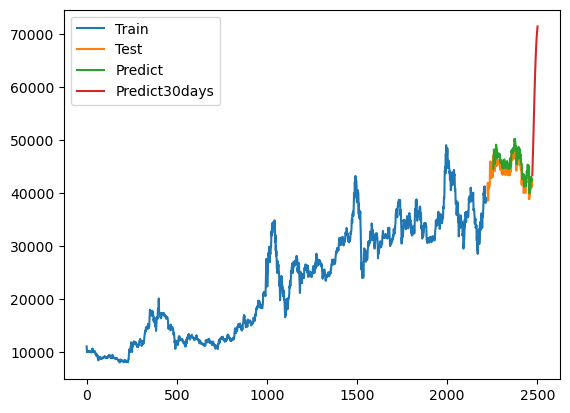

In [42]:
# Plot 
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_lstm)

predict_data_index = pd.RangeIndex(start=len(df), stop=len(df)+30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()